In [32]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [33]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
data = pd.read_csv('insurance.csv')
data.tail()

--2024-11-14 23:11:44--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.4’

insurance.csv.4     100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2024-11-14 23:11:44 (4.79 MB/s) - ‘insurance.csv.4’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [34]:
# Preprocess data
# Convert categorical data to numerical data
data['sex'] = data['sex'].map({'male': 0, 'female': 1})
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})
data['region'] = data['region'].map({'southeast': 0, 'southwest': 1, 'northeast': 2, 'northwest': 3})

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

# Scale features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_dataset = scaler.fit_transform(train_dataset)
test_dataset = scaler.transform(test_dataset)

# Remove outliers in expenses greater than 3 standard deviations
z_scores = np.abs((train_labels - train_labels.mean()) / train_labels.std())
mask = z_scores < 3

train_dataset = train_dataset[mask]
train_labels = train_labels[mask]

# Normalize labels
train_labels_mean = train_labels.mean()
train_labels_std = train_labels.std()

train_labels = (train_labels - train_labels_mean) / train_labels_std
test_labels = (test_labels - train_labels_mean) / train_labels_std

# Get the number of features
input_shape = train_dataset.shape[1]

# Build a deeper model with more stable activation functions and Batch Normalization
def build_model():
    model = keras.Sequential([
        layers.Dense(256, kernel_initializer='he_normal', input_shape=[input_shape]),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(128, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(64, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(32, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.0)

    model.compile(loss='mae',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

model = build_model()

# Train the model with adjusted batch size and callbacks
EPOCHS = 1000

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, verbose=1)

history = model.fit(
    train_dataset, train_labels,
    epochs=EPOCHS, validation_split=0.2, batch_size=32, verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        lr_schedule
    ])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 193: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 218: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 230: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 240: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.


9/9 - 0s - 4ms/step - loss: 0.2213 - mae: 0.2213 - mse: 0.1690
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing set Mean Abs Error: 2556.56 expenses
You passed the challenge. Great job!


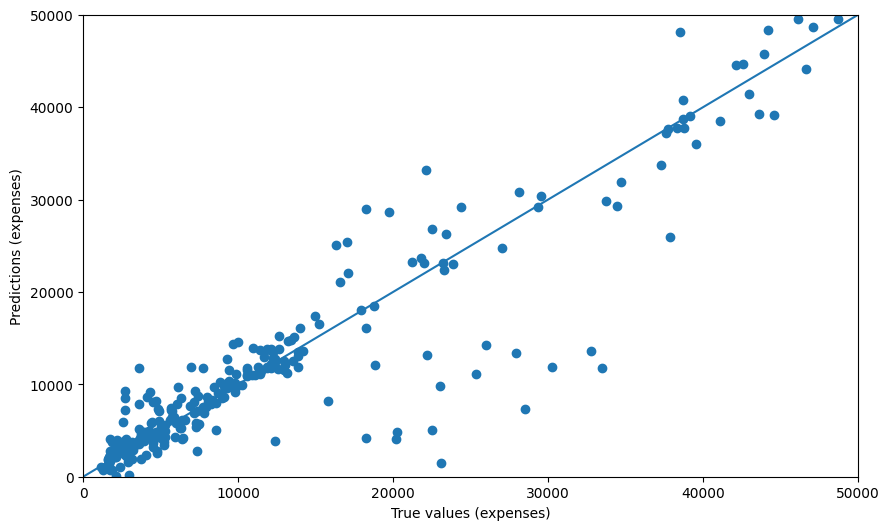

In [35]:
# Evaluate the model using the test dataset
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

# Rescale predictions back to original scale
test_labels = (test_labels * train_labels_std) + train_labels_mean
test_predictions = model.predict(test_dataset).flatten()
test_predictions = (test_predictions * train_labels_std) + train_labels_mean

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae * train_labels_std))  # Adjust MAE to original scale

if mae * train_labels_std < 3500:
    print("You passed the challenge. Great job!")
else:
    print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)